# Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

2024-05-27 14:20:59.850718: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 14:20:59.850817: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 14:20:59.947449: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load and Prepare Data

In [2]:
# Load datasets
val_data = pd.read_csv('/kaggle/input/emotion-dataset/validation.csv')
train_data = pd.read_csv('/kaggle/input/emotion-dataset/training.csv')
test_data = pd.read_csv('/kaggle/input/emotion-dataset/test.csv')

# Print dataset shapes
print(f"Validation data: {val_data.shape}")
print(f"Training data: {train_data.shape}")
print(f"Test data: {test_data.shape}")

# Label mapping dictionary
labels_dict = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
train_data['label_name'] = train_data['label'].map(labels_dict)

Validation data: (2000, 2)
Training data: (16000, 2)
Test data: (2000, 2)


# Data Preprocessing

In [4]:
# Initialize PorterStemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Function to preprocess data with stemming and stopword removal
def preprocess_text(text):
    tokens = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    return " ".join(tokens)

# Apply preprocessing to datasets
train_data['clean_text'] = train_data['text'].apply(preprocess_text)
val_data['clean_text'] = val_data['text'].apply(preprocess_text)
test_data['clean_text'] = test_data['text'].apply(preprocess_text)

# Create a tokenizer with combined training, validation, and test data
all_texts = train_data['clean_text'].tolist() + test_data['clean_text'].tolist() + val_data['clean_text'].tolist()
tokenizer = Tokenizer(num_words=16000)
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
print(f"Number of words without Stemming: {len(word_index)}")

# Function to preprocess data with stemming and tokenization
def preprocess_data(data):
    processed_data = []
    for _, row in data.iterrows():
        sequence = tokenizer.texts_to_sequences([row['clean_text'].split()])[0]
        processed_data.append([sequence, row['label']])
    return processed_data

Number of words without Stemming: 11598


# Build and Train Model

In [17]:
# Preprocess training and validation datasets
train_data_processed = preprocess_data(train_data)
val_data_processed = preprocess_data(val_data)

# Separate features and labels, and pad sequences
max_seq_length = max(len(seq[0]) for seq in train_data_processed)
train_X = pad_sequences([row[0] for row in train_data_processed], maxlen=max_seq_length, padding='post')
train_y = np.array([row[1] for row in train_data_processed])

val_X = pad_sequences([row[0] for row in val_data_processed], maxlen=max_seq_length, padding='post')
val_y = np.array([row[1] for row in val_data_processed])

# Convert labels to one-hot encoding
num_classes = len(labels_dict)
train_y_one_hot = to_categorical(train_y, num_classes=num_classes)
val_y_one_hot = to_categorical(val_y, num_classes=num_classes)

print(f"Training set shape: {train_X.shape}, {train_y.shape}")
print(f"Validation set shape: {val_X.shape}, {val_y.shape}")

# Build an optimized bidirectional LSTM model
model = Sequential([
    Embedding(input_dim=16000, output_dim=300, input_length=max_seq_length),
    LSTM(32, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.003)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(train_X, train_y_one_hot, epochs=15, validation_data=(val_X, val_y_one_hot), verbose=1)

Training set shape: (16000, 35), (16000,)
Validation set shape: (2000, 35), (2000,)
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.3214 - loss: 1.6084 - val_accuracy: 0.3190 - val_loss: 1.4237
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3845 - loss: 1.3563 - val_accuracy: 0.6065 - val_loss: 0.9977
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7403 - loss: 0.7602 - val_accuracy: 0.8635 - val_loss: 0.4401
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8963 - loss: 0.3483 - val_accuracy: 0.8815 - val_loss: 0.4032
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9217 - loss: 0.2445 - val_accuracy: 0.8845 - val_loss: 0.3999
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9397 - loss: 0.1887 - val_accuracy: 0.8835 - val_loss: 0.3767
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9516 - loss: 0.1534 - val_accuracy: 0.8885 - val_loss: 0.4389
Epoch 8/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9574 - loss: 0.1351 - val_accuracy: 0.8860 - val_

# Evaluation and Prediction

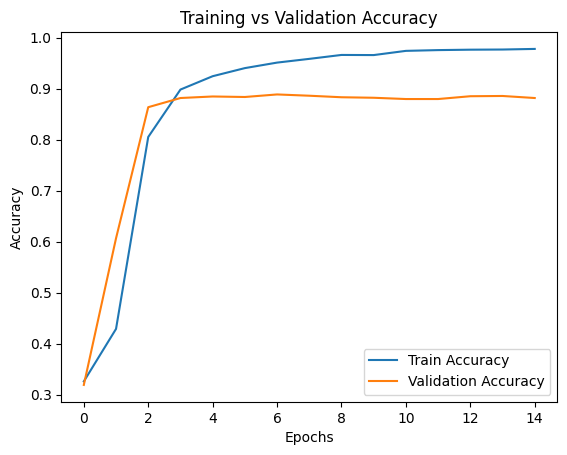

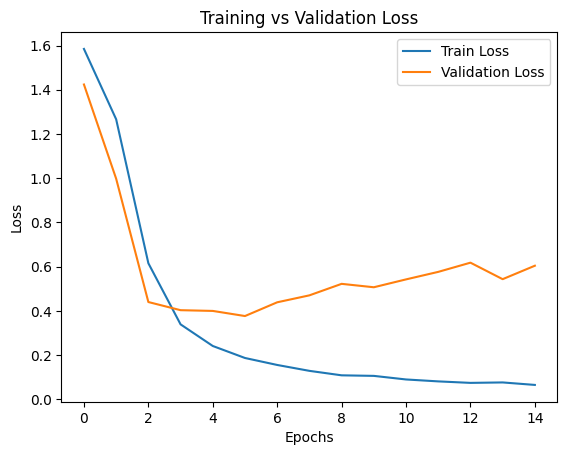

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step

Predicted: sadness, Actual: sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Predicted: sadness, Actual: sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

Predicted: joy, Actual: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Predicted: joy, Actual: joy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

Predicted: joy, Actual: sadness
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [18]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Function to predict on test data
def predict_text(text):
    sequence = tokenizer.texts_to_sequences([preprocess_text(text).split()])[0]
    sequence_padded = pad_sequences([sequence], maxlen=max_seq_length, padding='post')
    prediction = model.predict(sequence_padded)
    return np.argmax(prediction)

# Random predictions for testing
for _ in range(5):
    index = random.randint(0, len(test_data) - 1)
    predicted_class = predict_text(test_data['text'][index])
    actual_class = test_data['label'][index]
    print(f"\nPredicted: {labels_dict[predicted_class]}, Actual: {labels_dict[actual_class]}")

# Evaluate on entire test set
test_data_processed = preprocess_data(test_data)
test_X = pad_sequences([row[0] for row in test_data_processed], maxlen=max_seq_length, padding='post')
test_y = np.array([row[1] for row in test_data_processed])

test_y_one_hot = to_categorical(test_y, num_classes=num_classes)

# Predict classes
y_pred = model.predict(test_X)
y_pred_classes = np.argmax(y_pred, axis=1)

In [19]:
from sklearn.metrics import classification_report

print(classification_report(test_y, y_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       581
           1       0.89      0.92      0.90       695
           2       0.78      0.62      0.69       159
           3       0.86      0.90      0.88       275
           4       0.82      0.89      0.85       224
           5       0.71      0.74      0.73        66

    accuracy                           0.88      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.88      0.88      0.88      2000



In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_model, y_true, labels):
    cm = confusion_matrix(y_true,y_model,normalize='true')
    fig, ax = plt.subplots(figsize=(7,7))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
    disp.plot(ax=ax, colorbar=False)
    plt.title("Confusion matrix")
#     plt.axis('off')
    plt.grid(False)
    plt.show()

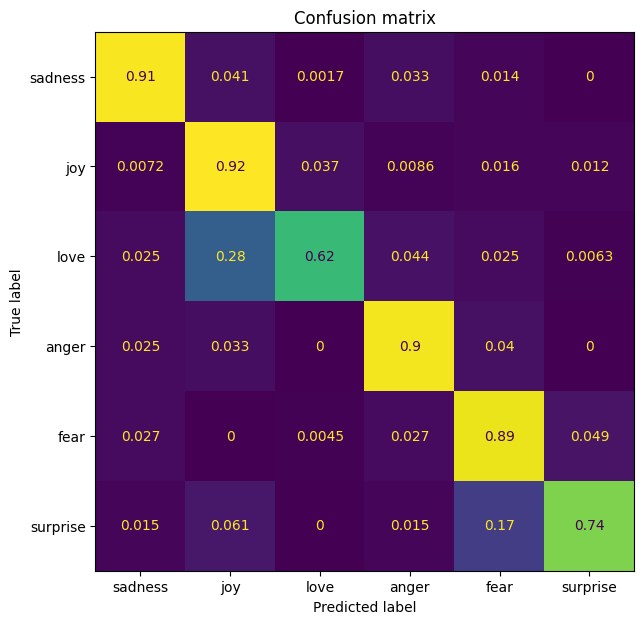

In [21]:
plot_confusion_matrix(y_pred_classes, test_y, labels_dict.values())